
![logo](./kfupm-logo.png)
## <center> ICS 485: Machine Learning
### <center> <font color=crimson> App Review Classification
<hr>


<center>
         <font color="pink" size=5> Team Members
        
        # Mawiah Alboainain
        # Yousef Alzahrani
 <hr>


    
    
Table of Contents
* [Exploratory Analysis](#first-bullet)
* [Imbalanced Data](#fourth-bullet)
* [Evaluation Measures](#fifth-bullet)
* [Classifiers](#sixth-bullet)
* [Hyper-parameter Tuning ](#seventh-bullet)
* [Error Analysis](#eighth-bullet)
* [Results](#ninth-bullet)
* [Conclusion](#tenth-bullet)


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#text editing libraries
import nlpaug
import nlpaug.augmenter.word as naw
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize



## Helper Methods

In [4]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]"," ",str(text)) #force string
    text = re.sub(r"(^|\W)\d+", "", text)
    text = text.lower()
    lemmatizer=WordNetLemmatizer()
    text=word_tokenize(text)
    tmp =''
    for word in text:
        tmp+=lemmatizer.lemmatize(word)+' '
    text = tmp
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [5]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=10)   
def text_augment(text):
    return aug.augment(text,n=1)

In [19]:
def undersample(df):
    classes = df.label.value_counts().to_dict()
    downsize = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)):
        classes_sample.append(classes_list[i].sample(downsize, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [18]:
def oversample(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    to_augment =  max(classes.values()) - np.array(list(classes.values()))
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        to_paraphrase = classes_list[i].sample(to_augment[i], replace=True)
        to_paraphrase.review = to_paraphrase.apply(lambda x: text_augment(x['review']), axis=1)
        classes_sample.append(to_paraphrase)
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0],classes_list[1],classes_list[2],classes_list[3]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [20]:
dataset_url = "https://raw.githubusercontent.com/ZYousef/CS485-Project/main/AppReviews-FourClasses.csv"
df = pd.read_csv(dataset_url)

## <center><font color=purple> 1. Exploratory Data Analysis<a class="anchor" id="first-bullet"></a>
<hr>

### <font color=blue> A. Dataset Analysis & Important Statistics

In [ ]:
#Dataset analysis and report on important statistics

In [6]:
df.head()

,review,label
0,"Besides the occasional crash, this is an amazi...",Bug
1,This could be a great app if it was predictabl...,Bug
2,I can't open since the last 2 updates Pop-ups ...,Bug
3,Use to love this app but it's not working afte...,Bug
4,"Urrrrm\tAfter my third re installing, it final...",Bug


In [7]:
df.describe()

,review,label
count,3733,3733
unique,3217,4
top,Good,Rating
freq,15,2461


We have 3733 reviews, 3217 of them are unique.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3733 entries, 0 to 3732
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3733 non-null   object
 1   label   3733 non-null   object
dtypes: object(2)
memory usage: 58.5+ KB


In [9]:
samples,classes=df.shape[0],df.nunique()[1]

In [10]:
samples,classes

(3733, 4)

We have 3733 Samples & 4 unique classes

In [11]:
df.label.value_counts()

Rating            2461
UserExperience     607
Bug                370
Feature            295
Name: label, dtype: int64

Rating, UserExperience, Bug & Features are the four unique classes. We can also notice an imbalance in classes with Rating dominating by a large margin.

In [12]:
#Some reviews contains special string such as \t & \n for tabs and new line
df[df.review.str.contains("\t")].shape[0],df[df.review.str.contains("\n")].shape[0]

(1491, 238)

In [13]:
df.review = df.review.str.replace("\n"," ")
df.review = df.review.str.replace("\t"," ")

In [14]:
df[df.review.str.contains("\t")].shape[0],df[df.review.str.contains("\n")].shape[0]

(0, 0)

In [15]:
#Dealing with duplicated data
df[df.duplicated()]

,review,label
223,"The white app icon is so atrocious, I'm hiding...",Bug
714,Nice,Rating
752,Good Good,Rating
786,Good,Rating
820,Ok,Rating
...,...,...
3060,Good Cool,Rating
3063,Ok Ok,Rating
3075,Great app,Rating
3085,Ok,Rating


We notice 137 entries are duplicated

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df[df.duplicated()]

,review,label


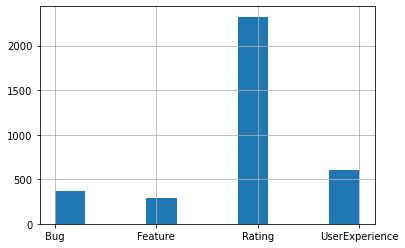

In [18]:
df.label.hist();

In [19]:
 df.label.value_counts()

Rating            2324
UserExperience     607
Bug                369
Feature            295
Name: label, dtype: int64

In [20]:
 df.label.value_counts()

Rating            2324
UserExperience     607
Bug                369
Feature            295
Name: label, dtype: int64

## <center><font color=purple>4. Imbalanced Data<a class="anchor" id="fourth-bullet"></a>
<hr>

**The next few cells is method used in dealing with imbalanced data**

<font color=purple>
    
We've attempted 5 different blanacing techniques, simple Undersampling & Oversampling, Random Undersampling & Oversampling, and finally text augmentation using a paraphrasing library.

In [21]:
#Blanaces the data and makes sure new aguments data duplicates are <=25 or reached limit
df_balanced = oversample(df)
dups = df_balanced.duplicated().sum()
num_iter=0
while num_iter < 10 & dups > 25 :
    df_balanced.drop_duplicates(inplace=True)
    df_balanced = oversample(df)
    dups = df_balanced.duplicated().sum()
    num_iter+=1
#Make sure original dataset is embedded 
pd.merge(df,df_balanced,how='inner').shape[0]

3684

In [22]:
df_balanced.to_csv('balanced.csv',index=False)

In [23]:
df_balanced = pd.read_csv('balanced.csv')

In [24]:
df_balanced.label.value_counts()

UserExperience    2324
Bug               2324
Feature           2324
Rating            2324
Name: label, dtype: int64

**All classes with the same amount of data (2324)**

### <font color=blue> B. Correlation Analysis

In [25]:
df_balanced.review = df_balanced.apply(lambda x: clean_text(x['review']), axis=1)

In [26]:
df_balanced['review'].str.lower().str.split().apply(len).groupby(df_balanced.label).describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Bug,2324.0,40.406196,36.205128,2.0,19.0,31.0,49.0,278.0
Feature,2324.0,37.811102,35.534369,3.0,18.0,29.5,45.0,277.0
Rating,2324.0,13.885972,19.373360,0.0,3.0,7.0,17.0,272.0
UserExperience,2324.0,33.649312,30.247588,1.0,13.0,25.0,45.0,260.0


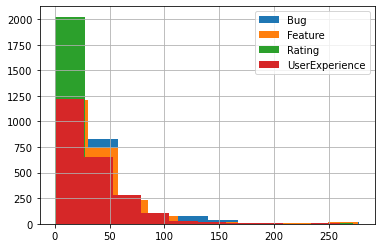

In [27]:
df_balanced['review'].str.lower().str.split().apply(len).groupby(df_balanced.label).hist(legend=True);

#### Ratings review are relatively short

In [28]:
df_balanced['label_id'] = df_balanced['label'].factorize()[0] #digitze? label to int
label_id_df_balanced = df_balanced[['label', 'label_id']].sort_values('label_id') #sort
label_to_id = dict(label_id_df_balanced.values)
id_to_label = dict(label_id_df_balanced[['label_id', 'label']].values)

In [29]:
X,Y = df_balanced['review'], df_balanced['label']
trainx, testx, trainy, testy = train_test_split(X, Y, test_size=0.3, random_state=777)

In [30]:
#Text represntation
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(trainx).toarray()
labels = trainy.factorize()[0]
features.shape

(6507, 48595)

In [31]:
N = 2
for label, label_id in sorted(label_to_id.items()):
  features_chi2 = chi2(features, labels == label_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bug':
  . Most correlated unigrams:
. love
. game
  . Most correlated bigrams:
. whatsapp sm
. useful easy
# 'Feature':
  . Most correlated unigrams:
. trip
. easy
  . Most correlated bigrams:
. trip advisor
. easy use
# 'Rating':
  . Most correlated unigrams:
. nice
. good
  . Most correlated bigrams:
. good good
. information technology
# 'UserExperience':
  . Most correlated unigrams:
. fix
. crash
  . Most correlated bigrams:
. update fix
. latest update


## <center><font color=purple>5. Evaluation Measures <a class="anchor" id="fifth-bullet"></a>
<hr>

#### In our project we're going to use the classification report provided by sklearn
#### It is a performance evaluation metric in machine learning which is used to show the precision, recall, F1 Score, and support score of your trained classification model.
    
    sklearn.metrics.classification_report
#### Check [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report) for more details 

 

The reason this report is used because it shows the main classification metrics
precision, recall and f1-score on a per-class basis.
The metrics are calculated by using true and false positives, true and false negatives.
Positive and negative in this case are generic names for the predicted classes.

it measures the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report as will be shown below. 

## <center><font color=purple>6. Classifers <a class="anchor" id="sixth-bullet"></a>
<hr>

* Naive Bayes
* Logistic Regression
* Support Victor Machines (Linear & SGD)
* Random Forest

**Naive Bayes**: In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation.

**Justification**: After doing a lot of research, we found out that 
The Naive Bayesian classifier consists of performing the below steps –

- Create a frequency table based on the words
- Calculate the likelihood for each of the classes based on the frequency table
- Calculate the posterior probability for each class
- The highest posterior probability is the outcome of the prediction experiment

All these probabilities are calculated by using the Bayes Theorem and this will help us in our App Reviews Classification problem

**Logistic Regression**: Logistic Regression is a Machine Learning algorithm which is used for the classification problems, it is a predictive analysis algorithm and based on the concept of probability. The Logistic Regression uses a more complex cost function, this cost function can be defined as the ‘Sigmoid function’ or also known as the ‘logistic function’ instead of a linear function.

**Justification**: After doing a lot of research in text classification, we found out that Logistic regression is a simple and easy to understand classification algorithm, and Logistic regression can be easily generalized to multiple classes. Furthermore, it is widely used in multi-class text classification problems. 


**SVM**: SVM is a supervised machine learning algorithm that can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is a number of features you have) with the value of each feature being the value of a particular coordinate.

In its most simple type, SVM doesn’t support multiclass classification natively. It supports binary classification and separating data points into two classes. For multiclass classification, such as, our project, the same principle is utilized after breaking down the multiclassification problem into multiple binary classification problems.

**Justification**: After doing a lot of research in text classification, we found out that (SVM) has proven to be an eﬀective multiclass text classiﬁer. "In 1997 Joachims published results on a set of binary text classiﬁcation experiments using the Support Vector Machine. The SVM yielded lower error than many other classiﬁcation techniques".

Moreover, two other scientists followed two years later with experiments of their own on the same data set. They used improved versions of other classifiers but still found that the SVM performed at least as well as all other classiﬁers they tried, and for that reason we have decided to try both linear SVM & SGD to trsin SVM in our project. 

**Random Forest**: A random forest is a machine learning technique that's used to solve regression and classification problems. It utilizes ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems. A random forest algorithm consists of many decision trees.

**Justification**: Random Forests are an ensemble method which trains a bunch of decision trees (hence the ‘forest’) to try and combat overfitting which decision trees are prone to. It does this by averaging the predictions of the different decision trees which can reduce the variance. Tuning models is all about finding the best balance between bias and variance. 

## <center><font color=purple>7. Hyper-parameter Tuning <a class="anchor" id="seventh-bullet"></a>

#### In this section we've pipelined all of our classifiers to automate the process of tunning the paramters using GridSearchCV , 

    from sklearn.model_selection import GridSearchCV


#### If you want to know the results of GridSearchCV use,

    clf.best_estimator_

## Naive Bayes

In [32]:
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2,1e-3,1e-4]
}
#tuned_parameters = {}

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.8992    0.9692    0.9329       681
       Feature     0.8403    0.9582    0.8954       670
        Rating     0.8171    0.6059    0.6959       708
UserExperience     0.7807    0.8192    0.7995       730

      accuracy                         0.8351      2789
     macro avg     0.8343    0.8381    0.8309      2789
  weighted avg     0.8332    0.8351    0.8288      2789



## Logisitc Regression

In [40]:
# Using logistic regression as a classification model using Spark
# Building the model
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0, C=1e5)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__n_jobs': [1,2],
}

# Fitting the model built above in the training set and then testing it
# and printing different reports along with the accuracy 
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.9235    0.9574    0.9402       681
       Feature     0.9167    0.9030    0.9098       670
        Rating     0.7113    0.7585    0.7341       708
UserExperience     0.7934    0.7260    0.7582       730

      accuracy                         0.8333      2789
     macro avg     0.8362    0.8362    0.8356      2789
  weighted avg     0.8339    0.8333    0.8329      2789



## Support Vector Machine (SVM)

#### A) SVM with SGD training

In [33]:
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=42)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2,1e-3,1e-4],
    'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'clf__penalty':['l2', 'l1', 'elasticnet'],
    'clf__max_iter': [1000,2000,3000]
}

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.9233    0.9721    0.9471       681
       Feature     0.8859    0.9731    0.9275       670
        Rating     0.8194    0.7048    0.7578       708
UserExperience     0.8102    0.8068    0.8085       730

      accuracy                         0.8612      2789
     macro avg     0.8597    0.8642    0.8602      2789
  weighted avg     0.8583    0.8612    0.8580      2789



#### B) Linear SVM

In [41]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(random_state=42)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'clf__penalty':['l2', 'l1'],
}

clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")

## Testing the model and printing the accuracy
regr.fit(trainx, trainy)
print(classification_report(testy, regr.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.9057    0.9736    0.9384       681
       Feature     0.9050    0.9522    0.9280       670
        Rating     0.7883    0.7415    0.7642       708
UserExperience     0.8236    0.7740    0.7980       730

      accuracy                         0.8573      2789
     macro avg     0.8557    0.8603    0.8572      2789
  weighted avg     0.8542    0.8573    0.8549      2789



# Random Forest 

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=0)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_depth': [3,4,5],
    'clf__n_estimators':[200, 300],
}

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.7397    0.7386    0.7392       681
       Feature     0.6787    0.7597    0.7169       670
        Rating     0.5967    0.7669    0.6712       708
UserExperience     0.7261    0.4466    0.5530       730

      accuracy                         0.6744      2789
     macro avg     0.6853    0.6780    0.6701      2789
  weighted avg     0.6852    0.6744    0.6678      2789



## <font color=orange> Notes

#### <font color=orange>Undersampling using our method without libraries performed around 43% accuracy.
        undersample(df);

#### <font color=orange>Use,
    
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
#### <font color=orange>Then include it as follows:

        text_clf = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('RUS', RandomOverSampler()),  *OR*  ('RUS', RandomUnderSampler()), 
                        ('clf', MultinomialNB())])

#### <font color=orange>Undersampling using library resulted in around 50% accuracy 
#### <font color=orange>Oversampling performed better at around 64% accuracy
#### <font color=orange>However, our best result was through data augmenting by generating new parapharsed data. 

## <center><font color=purple>8. Error Analysis & Possible Improvements <a class="anchor" id="eighth-bullet"></a>
<hr>

* Oversampling Training data only instead of the whole dataset. 

Copies of the same point may end up in both the training and test sets. This allows the classifier to cheat, because when trying to make predictions on the test set the classifier will already have seen identical points in the train set. However, in our project we believe that it should not effect much since we have a small data and we have done data preprocessing and deleted replicated data (if any). 
<hr>

* In RandomForest we could see that it performs worse than most classifer, even though it shouldn't.
    This is because we're using a basic estimaitor, using tunned base_estimators would definility results an exceeding performance.

<hr>

* Using different text augmentation
    
Data augmentation is a data oversampling technique used to increase the size of the data by adding new samples that have a similar distribution to the original data or marginally altering the original data. The data needs to be altered in a way that preserves the class label for better performance at the classification task.

A possible improvment is using diffrent techniques, such as:
   
Different Synonym Word Replacement    
    - Word Embedding based Replacement: Pretrained word embedding like GloVe.
    - Lexical based Replacement: Wordnet
    
Generative Models
    Generative language models such as BERT, RoBERTa, BART or the recent T5 model can be used to generate the text in a more class label preserving manner. The generative model encodes the class label along with its associated text sequences to generate newer samples with some modifications. The approach is usually more reliable and the sample generated are more representative of the associated class label.
    
Random Insertion / Swapping / Deletion
    - Random Insertion: Identifying and extracting synonyms for some randomly chosen words that are not StopWords in 
    the sentence. Inserting this identified synonym at some random position in the sentence.
    
    - Random Swapping: Randomly choosing two words in the sentence and swap their positions. This may not be a good 
    idea in a morphologically rich language like Hindi, Marathi as it may entirely change the meaning of the sentence.
    
    - Random Deletion: Randomly removing word in the sentence.

    





## <center><font color=purple>9. Final Results <a class="anchor" id="ninth-bullet"></a>
<hr>

| Classifier| Accuracy |  |
| --- | --- | --- |
| Naive Bayes |  | 0.8351       |
| Logisitc Regression |  | 0.8333       |
| SVM SGD |  | 0.8612       |
| SVM Linear |  | 0.8573       |
| RandomForest |  | 0.6744       |

- Naive Bayes: Achieved accuracy score of 83.51%.
- Logistic Regression: Achieved a lower accuracy score of 83.33%.
- SVM SGD: Achieved a higher accuracy score of 86.12% which is approximately 3% improvement over Naive Bayes.
- SVM Linear: Achieved a high accuracy score of 85.73% which is approximately 2% improvement over Naive Bayes but slightly less than SGD.
- Random Forest: Achieved accuracy score of 67.44% which is the least score between all classifiers.

## <center><font color=purple>10. Conclusion <a class="anchor" id="tenth-bullet"></a>
<hr>

In conclusion, we have done some data preprocessing on the App Reviews dataset, such as, data cleaning, data transformation. Unbalanced data were dealt with by using both data oversampling & undersampling. Moreover, few evaluation measures were used from the classification report, such as, precision, recall, F1 Score, and support score.

Four classifers were used in our project, Naive Bayes, Logistic Regression, SVM and Random Forest, with almost similar accuracy between them. Furthermore, we have shown that the Support Vector Machine can perform multiclass text classiﬁcation very eﬀectively and slightly better than Naive Bayes and Logistic Regression. Moreover, hyperparameter optimization or tuning using GridSearchCV gave us a better result on the test set. 

# <font color=blue> Resources: Here is a list of diffrent articles & research the we have used in our project
    
    
* https://analyticsindiamag.com/naive-bayes-why-is-it-favoured-for-text-related-tasks/
* https://www.researchgate.net/publication/2522390_Improving_Multiclass_Text_Classification_with_the_Support_Vector_Machine
* https://www.baeldung.com/cs/svm-multiclass-classification
* https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
* https://muthu.co/understanding-the-classification-report-in-sklearn/
* https://saurabhk30.medium.com/5-data-augmentation-techniques-for-text-classification-d14f6d8bd6aa
